# TAD Pictures Productions Analysis of Movie Studio Profits in the US

## BLUF
- Disney has profited the most domestically by over $1B 
- Movies perform best in summer
- The top genres in the US are adventure, comedy and action


## Introduction
TAD Pictures, a theoretical stakeholder, is seeking to create a new movie studio. They are hoping to release movies in the US and maximize profits as they begin this new venture. They have tasked us with analying the movie industry to determine the best practices moving forward.

Data was taken from 3 sources - IMDb, Box Office Mojo, the Numbers. The metric we used for success was domestic profit. Data was taken between the years of 2010 and 2018.

## Table of Contents 
- Data Exploring
    - SQL Database
    - .csv and .tsv files
- Data Cleaning
    - Stripping spaces and punctuations from movie titles
    - Standardizing specific columns and rows
- Merging the DataFrames
    - Merging DataFrames
    - Deleting Unnecessary Columns
    - Creating a column for ROI
    - Filling in missing values
- Visualizations
    - Top 25 studios with the highest 'domestic_gross'
    - Top 25 genres with the highest 'domestic_Profit'
- Simple Linear Regression Model

In this notebook, we'll conduct data cleaning and filtering tasks across various datasets containing movie details spanning different years. Our objective is to explore the data and identify movies that are performing well in the box office.

In [301]:
#We import all the packages needed.
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import string
import matplotlib as plt 
import sqlite3
import zipfile
import seaborn as sns
from scipy import stats
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm

In [302]:
#!pip install --upgrade pandas

In [303]:
#We read in all the data using Pandas and assigned them to their df variable respectively.
df = pd.read_csv("./zippedData/bom.movie_gross.csv.gz")
#df2 = pd.read_csv("./zippedData/im.db.zip", encoding='utf-8')
df3 = pd.read_csv("./zippedData/rt.movie_info.tsv.gz", sep='\t')
df4 = pd.read_csv("./zippedData/rt.reviews.tsv.gz", encoding='latin-1', sep='\t', compression='gzip')
df5 = pd.read_csv("./zippedData/tmdb.movies.csv.gz")
df6 = pd.read_csv("./zippedData/tn.movie_budgets.csv.gz")

In [304]:
#We read in the sql datatables
conn = sqlite3.connect('./zippedData/im.db')

# Data Exploring

### Q1

We start first looking into the sql data. 

In [305]:
#We looked at all the tables in the sql data
pd.read_sql(
'''
SELECT * 
FROM sqlite_master 
''', conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [306]:
#We looked at the movie_basics table
pd.read_sql(
'''
SELECT * 
FROM movie_basics 
''', conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [307]:
#We looked at all the tables in the sql data
pd.read_sql(
'''
SELECT * 
FROM movie_ratings 
''', conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


## ADD CELLS LOOKING INTO MOVIEBASICS AND MOVIERATINGS

We decided to use the two tables movie_basics and movie_ratings and join them together to get the titles, start year, genres, averagerating, and numvotes for years in 2010 to 2018.

We then turned this joined table into a pandas dataframe.

In [308]:
#joining tables and looking at the movies with the top number of votes
# should we create a metric for this? ie looking for movies with at least 1,000 votes?

pd. read_sql(
    '''SELECT * 
    FROM movie_basics as mb
    JOIN movie_ratings as mr
    ON mb.movie_id = mr.movie_id
    ORDER BY numvotes DESC
    LIMIT 10 ''', conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",tt1375666,8.8,1841066
1,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",tt1345836,8.4,1387769
2,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",tt0816692,8.6,1299334
3,tt1853728,Django Unchained,Django Unchained,2012,165.0,"Drama,Western",tt1853728,8.4,1211405
4,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",tt0848228,8.1,1183655
5,tt0993846,The Wolf of Wall Street,The Wolf of Wall Street,2013,180.0,"Biography,Crime,Drama",tt0993846,8.2,1035358
6,tt1130884,Shutter Island,Shutter Island,2010,138.0,"Mystery,Thriller",tt1130884,8.1,1005960
7,tt2015381,Guardians of the Galaxy,Guardians of the Galaxy,2014,121.0,"Action,Adventure,Comedy",tt2015381,8.1,948394
8,tt1431045,Deadpool,Deadpool,2016,108.0,"Action,Adventure,Comedy",tt1431045,8.0,820847
9,tt1392170,The Hunger Games,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi",tt1392170,7.2,795227


In [309]:
#We executed the SQL query and stored the results in a pandas DataFrame
q1 = pd.read_sql('''
    SELECT mb.movie_id,
            mb.primary_title,
            mb.start_year,
            mb.genres,
            mr.averagerating,
            mr.numvotes
    FROM movie_basics as mb
    JOIN movie_ratings as mr
    ON mb.movie_id = mr.movie_id
    WHERE mb.start_year > 2008 AND mb.start_year < 2018
    AND mr.numvotes > 100000
    ORDER BY mr.averagerating DESC;
    ''', conn)

#We closed the database connection


# Now we have your SQL query result in a pandas DataFrame
print(q1)

      movie_id                     primary_title  start_year  \
0    tt5813916                   The Mountain II        2016   
1    tt1375666                         Inception        2010   
2    tt0816692                      Interstellar        2014   
3    tt1675434                  The Intouchables        2011   
4    tt2582802                          Whiplash        2014   
..         ...                               ...         ...   
576  tt1815862                       After Earth        2013   
577  tt1071875  Ghost Rider: Spirit of Vengeance        2011   
578  tt1502712                    Fantastic Four        2015   
579  tt0938283                The Last Airbender        2010   
580  tt2322441              Fifty Shades of Grey        2015   

                      genres  averagerating  numvotes  
0           Action,Drama,War            9.3    100568  
1    Action,Adventure,Sci-Fi            8.8   1841066  
2     Adventure,Drama,Sci-Fi            8.6   1299334  
3     B

## Next we look into the csv files 

In [310]:
df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [311]:
df3.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [312]:
df4.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [313]:
df5.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [314]:
df6.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Now we decided to only use q1, df, and df6

We decided to use q1,df, and df6 because they contained the titles, genres, studios, domestic profit, production budget, and release year.

These are the key columns we need to dig into our analysis.

# Data Cleaning

We first must clean up these three dataframes so that we can merge them properly.

We noticed that it would be best to merge these three dataframes on the movie titles column.

We first decide to takeout all the space and punctuation in the movie columns of each dataframe.

In [315]:
#We stripped the spaces and punctuations in the titles of the movies in q1

def strip_spaces_and_punctuation(value):
    if isinstance(value, str):
        translation_table = str.maketrans('', '', string.punctuation + ' ')
        return value.translate(translation_table)
    else:
        return value

#We applied the function to all values in the DataFrame
q1['primary_title'] = q1['primary_title'].apply(lambda x: strip_spaces_and_punctuation(x))
print(q1)


      movie_id                primary_title  start_year  \
0    tt5813916                TheMountainII        2016   
1    tt1375666                    Inception        2010   
2    tt0816692                 Interstellar        2014   
3    tt1675434              TheIntouchables        2011   
4    tt2582802                     Whiplash        2014   
..         ...                          ...         ...   
576  tt1815862                   AfterEarth        2013   
577  tt1071875  GhostRiderSpiritofVengeance        2011   
578  tt1502712                FantasticFour        2015   
579  tt0938283             TheLastAirbender        2010   
580  tt2322441            FiftyShadesofGrey        2015   

                      genres  averagerating  numvotes  
0           Action,Drama,War            9.3    100568  
1    Action,Adventure,Sci-Fi            8.8   1841066  
2     Adventure,Drama,Sci-Fi            8.6   1299334  
3     Biography,Comedy,Drama            8.5    677343  
4          

In [316]:
#We stripped the spaces and punctuations in the titles of the movies in df
def strip_spaces_and_punctuation(value):
    if isinstance(value, str):
        translation_table = str.maketrans('', '', string.punctuation + ' ')
        return value.translate(translation_table)
    else:
        return value

#We applied the function to all values in the DataFrame
df['title'] = df['title'].apply(lambda x: strip_spaces_and_punctuation(x))
print(df)

                                     title      studio  domestic_gross  \
0                                ToyStory3          BV     415000000.0   
1                    AliceinWonderland2010          BV     334200000.0   
2     HarryPotterandtheDeathlyHallowsPart1          WB     296000000.0   
3                                Inception          WB     292600000.0   
4                        ShrekForeverAfter        P/DW     238700000.0   
...                                    ...         ...             ...   
3382                              TheQuake       Magn.          6200.0   
3383                 EdwardII2018rerelease          FM          4800.0   
3384                               ElPacto        Sony          2500.0   
3385                               TheSwan  Synergetic          2400.0   
3386                       AnActorPrepares       Grav.          1700.0   

     foreign_gross  year  
0        652000000  2010  
1        691300000  2010  
2        664300000  2010  
3  

In [317]:
#We stripped the spaces and punctuations in the titles of the movies in df6
def strip_spaces_and_punctuation(value):
    if isinstance(value, str):
        translation_table = str.maketrans('', '', string.punctuation + ' ')
        return value.translate(translation_table)
    else:
        return value

#Apply the function to all values in the DataFrame
df6['movie'] = df6['movie'].apply(lambda x: strip_spaces_and_punctuation(x))
print(df6)

      id  release_date                                 movie  \
0      1  Dec 18, 2009                                Avatar   
1      2  May 20, 2011  PiratesoftheCaribbeanOnStrangerTides   
2      3   Jun 7, 2019                           DarkPhoenix   
3      4   May 1, 2015                   AvengersAgeofUltron   
4      5  Dec 15, 2017             StarWarsEpVIIITheLastJedi   
...   ..           ...                                   ...   
5777  78  Dec 31, 2018                                 Red11   
5778  79   Apr 2, 1999                             Following   
5779  80  Jul 13, 2005              ReturntotheLandofWonders   
5780  81  Sep 29, 2015                     APlagueSoPleasant   
5781  82   Aug 5, 2005                        MyDateWithDrew   

     production_budget domestic_gross worldwide_gross  
0         $425,000,000   $760,507,625  $2,776,345,279  
1         $410,600,000   $241,063,875  $1,045,663,875  
2         $350,000,000    $42,762,350    $149,762,350  
3      

Now that we stripped the spaces and puncatation in each dataframe movie columns, we now need to rename each column as the same name 'movie'.

In [318]:
#We renamed the 'primary_title' and 'title' to just 'movie' in q1 and df

q1.rename(columns={'primary_title': 'movie'}, inplace=True)
df.rename(columns={'title': 'movie'}, inplace=True)

Next we noticed that some titles of the movies are spelled a little differently in q1 and df6. We decided to make these titles name the same so that they merge properly because they are huge movies in the dataframes.

In [319]:
#We changed the names of these movies to match the same for merge purposes
df6['movie'] = df6['movie'].replace('StarWarsEpVIIITheLastJedi', 'StarWarsTheLastJedi')
df6['movie'] = df6['movie'].replace('StarWarsEpVIITheForceAwakens', 'StarWarsTheForceAwakens')
q1['movie'] = q1['movie'].replace('StarWarsEpisodeVIITheForceAwakens', 'StarWarsTheForceAwakens')

In [320]:
#We looked at the tiles that contain 'Trans' in q1 
q1[q1['movie'].str.contains('Trans')]

,movie_id,movie,start_year,genres,averagerating,numvotes
244,tt0837562,HotelTransylvania,2012,"Animation,Comedy,Family",7.1,204571
470,tt2209764,Transcendence,2014,"Action,Drama,Sci-Fi",6.3,204481
487,tt1399103,TransformersDarkoftheMoon,2011,"Action,Adventure,Sci-Fi",6.2,366409
551,tt2109248,TransformersAgeofExtinction,2014,"Action,Adventure,Sci-Fi",5.7,283486
572,tt3371366,TransformersTheLastKnight,2017,"Action,Adventure,Sci-Fi",5.2,119007


Now we need to filter q1 and df6 to the years of 2010 to 2018 since df is already filtered to those dates.

In [321]:
#We turned the 'release_dates' to datetime for df6 and then filtered for dates from 2010 to 2018
df6['release_date'] = pd.to_datetime(df6['release_date'])
df6 = df6.loc[(df6['release_date'] >= '2010-01-01') & (df6['release_date'] <= '2018-12-31')]

In [322]:
#We filtered for dates from 2010 to 2018 in q1
q1 = q1.loc[(q1['start_year'] >= 2010) & (q1['start_year'] <= 2018)]
q1['start_year'].value_counts()

start_year
2013    94
2011    83
2014    81
2012    73
2010    72
2016    69
2015    58
2017    51
Name: count, dtype: int64

# Merging the Dataframes

Now that we have each dataframe filtered for 2010 to 2018 and the 'movie' columns the same, we can now merge each together to create one dataframe.

In [323]:
#We merged the df6 to q1 on the 'movie' column
merged_df6_q1 = df6.merge(q1, how='left', on='movie')
merged_df6_q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2124 non-null   int64         
 1   release_date       2124 non-null   datetime64[ns]
 2   movie              2124 non-null   object        
 3   production_budget  2124 non-null   object        
 4   domestic_gross     2124 non-null   object        
 5   worldwide_gross    2124 non-null   object        
 6   movie_id           526 non-null    object        
 7   start_year         526 non-null    float64       
 8   genres             526 non-null    object        
 9   averagerating      526 non-null    float64       
 10  numvotes           526 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 182.7+ KB


In [324]:
#We merged the 'merged_df6_q1' to df on the 'movie' column
merged_df6_q1_df = merged_df6_q1.merge(df, how='left', on='movie')

In [325]:
merged_df6_q1_df.head()

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,movie_id,start_year,genres,averagerating,numvotes,studio,domestic_gross_y,foreign_gross,year
0,2,2011-05-20,PiratesoftheCaribbeanOnStrangerTides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,2011.0,"Action,Adventure,Fantasy",6.6,447624.0,BV,241100000.0,804600000,2011.0
1,4,2015-05-01,AvengersAgeofUltron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,2015.0,"Action,Adventure,Sci-Fi",7.3,665594.0,BV,459000000.0,946400000,2015.0
2,5,2017-12-15,StarWarsTheLastJedi,"$317,000,000","$620,181,382","$1,316,721,747",tt2527336,2017.0,"Action,Adventure,Fantasy",7.1,462903.0,BV,620200000.0,712400000,2017.0
3,6,2015-12-18,StarWarsTheForceAwakens,"$306,000,000","$936,662,225","$2,053,311,220",tt2488496,2015.0,"Action,Adventure,Fantasy",8.0,784780.0,BV,936700000.0,"1,131.6",2015.0
4,7,2018-04-27,AvengersInfinityWar,"$300,000,000","$678,815,482","$2,048,134,200",NaN,NaN,NaN,NaN,NaN,BV,678800000.0,"1,369.5",2018.0


Now that we have merged our data, we can now drop the unnecessary columns. 

In [326]:
#We dropped the columns that wasn't necessary for our analysis 
merged_df6_q1_df.drop(columns=['averagerating', 'movie_id', 'movie_id', 'start_year', 'worldwide_gross', 'year', 'domestic_gross_y', 'numvotes', 'id'], inplace=True)

merged_df6_q1_df.head()

,release_date,movie,production_budget,domestic_gross_x,genres,studio,foreign_gross
0,2011-05-20,PiratesoftheCaribbeanOnStrangerTides,"$410,600,000","$241,063,875","Action,Adventure,Fantasy",BV,804600000
1,2015-05-01,AvengersAgeofUltron,"$330,600,000","$459,005,868","Action,Adventure,Sci-Fi",BV,946400000
2,2017-12-15,StarWarsTheLastJedi,"$317,000,000","$620,181,382","Action,Adventure,Fantasy",BV,712400000
3,2015-12-18,StarWarsTheForceAwakens,"$306,000,000","$936,662,225","Action,Adventure,Fantasy",BV,"1,131.6"
4,2018-04-27,AvengersInfinityWar,"$300,000,000","$678,815,482",NaN,BV,"1,369.5"


Now we want to find the the domestic ROI and the domestic profits in the data.

First we must change our production_budget and domestic_gross_x into numerical values so that we can calculate the ROI and Profits.

In [327]:
#We stripped the '$' from the 'production_budget' and 'domestic_gross' column
merged_df6_q1_df['production_budget'] = merged_df6_q1_df['production_budget'].str.strip('$')
merged_df6_q1_df['domestic_gross_x'] = merged_df6_q1_df['domestic_gross_x'].str.strip('$')

#We stripped the commas and space from the 'production_budget' and 'domestic_gross_x' column
merged_df6_q1_df['production_budget'].replace(',', '', regex=True, inplace=True)
merged_df6_q1_df['domestic_gross_x'].replace(',', '', regex=True, inplace=True)

#We changed both these columns to numeric columns 
merged_df6_q1_df['production_budget'] = pd.to_numeric(merged_df6_q1_df['production_budget'], errors='coerce')
merged_df6_q1_df['domestic_gross_x'] = pd.to_numeric(merged_df6_q1_df['domestic_gross_x'], errors='coerce')


In [328]:
#We calculated the ROI and the profits of the datasets and made two new columns for each
merged_df6_q1_df['domestic_ROI_percent'] = ((merged_df6_q1_df['domestic_gross_x']) / (merged_df6_q1_df['production_budget'])) * 100
merged_df6_q1_df['domestic_Profit'] = (merged_df6_q1_df['domestic_gross_x']) - (merged_df6_q1_df['production_budget'])

Now we look back at our new dataframe with the dropped columns and added columns. 

We notice a couple key movies are missing either the 'genres' or the 'studio'. We used common knowledge of these films to put the in their correct 'genres' or 'studio'.

In [329]:
merged_df6_q1_df.loc[8, 'genres'] = 'Action,Adventure,Sci-Fi'
merged_df6_q1_df.loc[4, 'genres'] = 'Action,Adventure,Sci-Fi'
merged_df6_q1_df.loc[251, 'genres'] = 'Action,Adventure,Sci-Fi'
merged_df6_q1_df.loc[251, 'studio'] = 'Sony'
merged_df6_q1_df.loc[165, 'genres'] = 'Adventure,Drama,Fantasy'
merged_df6_q1_df.loc[167, 'genres'] = 'Adventure,Drama,Fantasy'
merged_df6_q1_df.loc[165, 'studio'] = 'WB'
merged_df6_q1_df.loc[167, 'studio'] = 'WB'
merged_df6_q1_df.loc[28, 'genres'] = 'Action,Adventure,Sci-Fi'
merged_df6_q1_df.loc[35, 'studio'] = 'BV'
merged_df6_q1_df.loc[25, 'studio'] = 'Sony'
merged_df6_q1_df.loc[19, 'studio'] = 'BV'
merged_df6_q1_df.loc[38, 'studio'] = 'BV'

In [330]:
#We renamed 'domestic_gross_x' to 'domestic_gross'
merged_df6_q1_df.rename(columns={'domestic_gross_x': 'domestic_gross'}, inplace=True)

In [331]:
merged_df6_q1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   release_date          2125 non-null   datetime64[ns]
 1   movie                 2125 non-null   object        
 2   production_budget     2125 non-null   int64         
 3   domestic_gross        2125 non-null   int64         
 4   genres                533 non-null    object        
 5   studio                1267 non-null   object        
 6   foreign_gross         1099 non-null   object        
 7   domestic_ROI_percent  2125 non-null   float64       
 8   domestic_Profit       2125 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 149.5+ KB


# Visualization 

Now that our data is cleaned and fitlered, we can now visualize our analysis for a better observation.

We first want to look at the top 25 studios who has the highest 'domestic_gross'

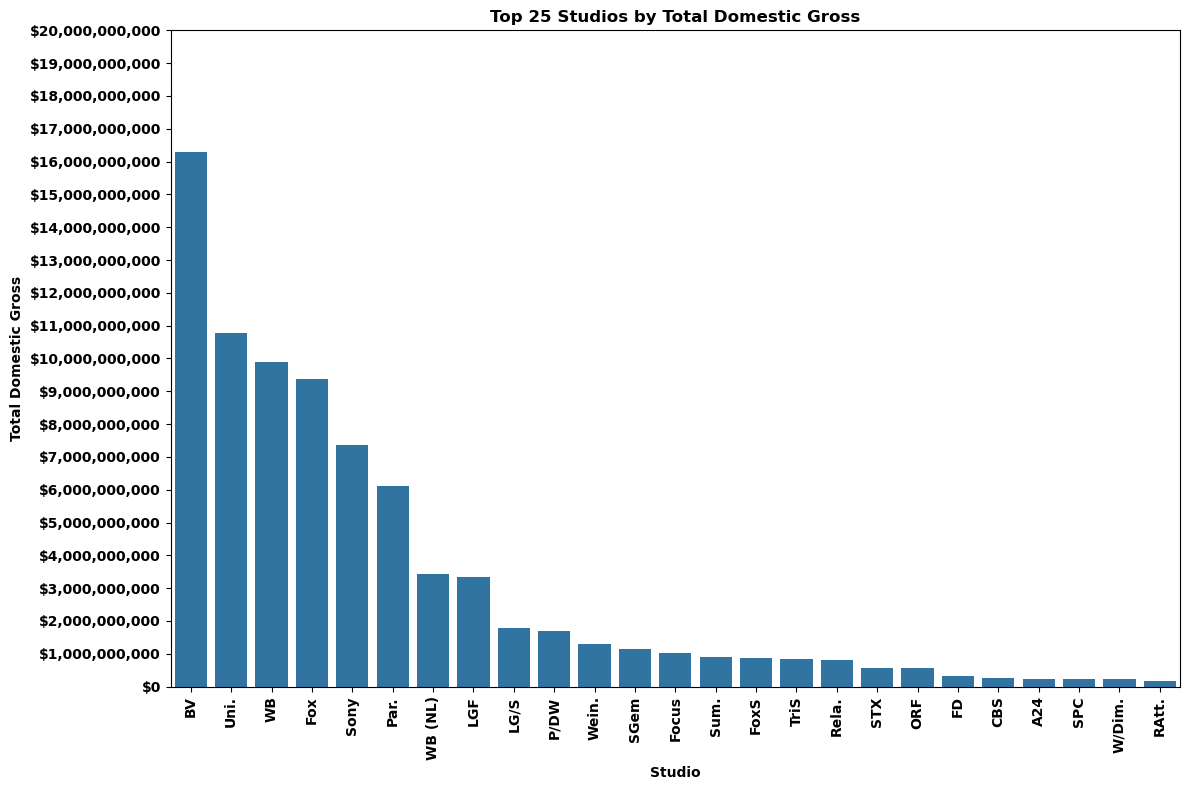

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 25 studios by domestic gross
top_studios_merged = merged_df6_q1_df.groupby('studio')['domestic_gross'].sum().nlargest(25).index

# Filter the DataFrame to include only the top 25 studios
df_top_25_merged = merged_df6_q1_df[merged_df6_q1_df['studio'].isin(top_studios_merged)]

# Calculate the total domestic gross for each studio
total_domestic_gross_merged = df_top_25_merged.groupby('studio')['domestic_gross'].sum().reset_index()

# Sort the studios based on their total domestic gross
sorted_studios_merged = total_domestic_gross_merged.sort_values(by='domestic_gross', ascending=False)['studio']

# Create a bar plot with studios ordered from greatest to least
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='studio', y='domestic_gross', data=df_top_25_merged, estimator=sum, errorbar=None, order=sorted_studios_merged)
plt.xlabel('Studio')
plt.ylabel('Total Domestic Gross')
plt.title('Top 25 Studios by Total Domestic Gross')
plt.xticks(rotation=90)

# Set the y-axis tick labels from 0 to 25,000,000,000
y_ticks = range(0, 20000000001, 1000000000)
barplot.set_yticks(y_ticks)
barplot.set_yticklabels(['${:,.0f}'.format(ytick) for ytick in y_ticks])

# Add text labels with each bar's value
#for index, row in total_domestic_gross.iterrows():
    #barplot.text(index, row['domestic_gross'], '${:,.0f}'.format(row['domestic_gross']), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Now we look at the top 25 studios with the highest 'domestic_ROI_percent'.

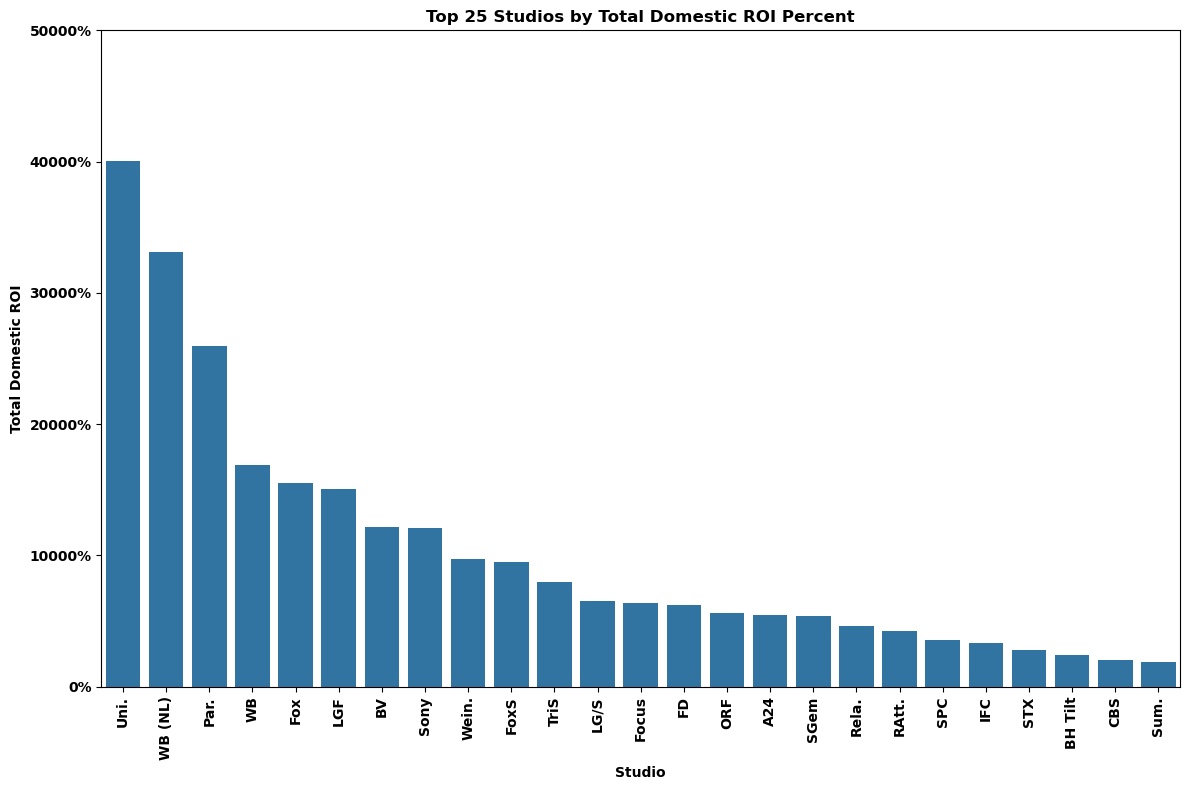

In [333]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 25 studios by domestic ROI
top_studios_merged_ROI = merged_df6_q1_df.groupby('studio')['domestic_ROI_percent'].sum().nlargest(25).index

# Filter the DataFrame to include only the top 25 studios
df_top_25_merged_ROI = merged_df6_q1_df[merged_df6_q1_df['studio'].isin(top_studios_merged_ROI)]

# Calculate the total domestic ROI for each studio
total_domestic_ROI_merged_ROI = df_top_25_merged_ROI.groupby('studio')['domestic_ROI_percent'].sum().reset_index()

# Sort the studios based on their total domestic ROI
sorted_studios_merged_ROI = total_domestic_ROI_merged_ROI.sort_values(by='domestic_ROI_percent', ascending=False)['studio']

# Create a bar plot with studios ordered from greatest to least
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='studio', y='domestic_ROI_percent', data=df_top_25_merged_ROI, estimator=sum, errorbar=None, order=sorted_studios_merged_ROI)
plt.xlabel('Studio')
plt.ylabel('Total Domestic ROI')
plt.title('Top 25 Studios by Total Domestic ROI Percent')
plt.xticks(rotation=90)

# Set the y-axis tick labels from 0 to 500 with increments of 500%
plt.yticks(range(0, 50001, 10000), ['{}%'.format(i) for i in range(0, 50001, 10000)])

plt.tight_layout()
plt.show()


Then we looked at the top 25 studios with 'domestic_Profit'.

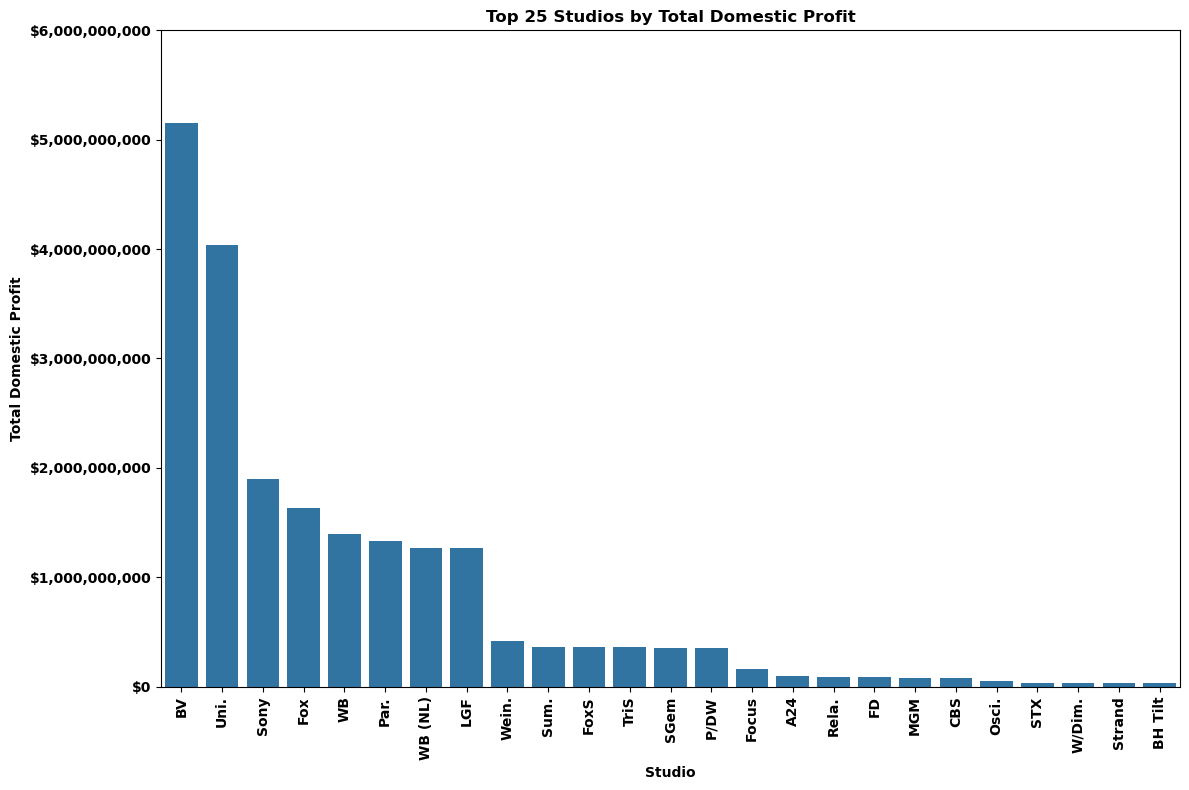

In [334]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 25 studios by domestic ROI
top_studios_merged_profit = merged_df6_q1_df.groupby('studio')['domestic_Profit'].sum().nlargest(25).index

# Filter the DataFrame to include only the top 25 studios
df_top_25_merged_profit = merged_df6_q1_df[merged_df6_q1_df['studio'].isin(top_studios_merged_profit)]

# Calculate the total domestic ROI for each studio
total_domestic_ROI_merged_profit = df_top_25_merged_profit.groupby('studio')['domestic_Profit'].sum().reset_index()

# Sort the studios based on their total domestic ROI
sorted_studios_merged_profit = total_domestic_ROI_merged_profit.sort_values(by='domestic_Profit', ascending=False)['studio']

# Create a bar plot with studios ordered from greatest to least
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='studio', y='domestic_Profit', data=df_top_25_merged_profit, estimator=sum, errorbar=None, order=sorted_studios_merged_profit)
plt.xlabel('Studio')
plt.ylabel('Total Domestic Profit')
plt.title('Top 25 Studios by Total Domestic Profit')
plt.xticks(rotation=90)

# Set the y-axis tick labels from 0 to 25,000,000,000
y_ticks = range(0, 6000000001, 1000000000)
barplot.set_yticks(y_ticks)
barplot.set_yticklabels(['${:,.0f}'.format(ytick) for ytick in y_ticks])

plt.tight_layout()
plt.show()


Last we look at the top 25 'genres' with the highest 'domestic_Profit'

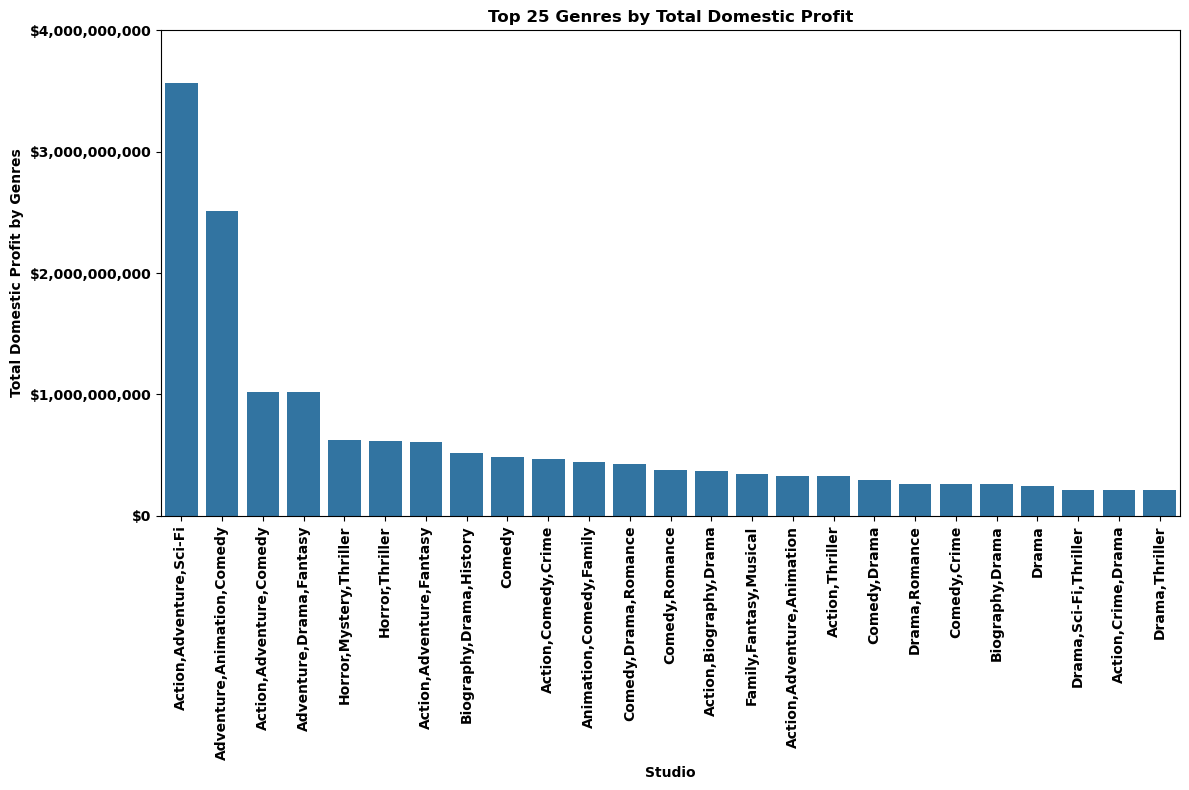

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 25 genre by domestic ROI
top_genre_merged_profit = merged_df6_q1_df.groupby('genres')['domestic_Profit'].sum().nlargest(25).index

# Filter the DataFrame to include only the top 25 studios
df_top_25_merged_genre_profit = merged_df6_q1_df[merged_df6_q1_df['genres'].isin(top_genre_merged_profit)]

# Calculate the total domestic ROI for each studio
total_genre_merged_profit = df_top_25_merged_genre_profit.groupby('genres')['domestic_Profit'].sum().reset_index()

# Sort the studios based on their total domestic ROI
sorted_genre_merged_profit = total_genre_merged_profit.sort_values(by='domestic_Profit', ascending=False)['genres']

# Create a bar plot with studios ordered from greatest to least
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='genres', y='domestic_Profit', data=df_top_25_merged_genre_profit, estimator=sum, errorbar=None, order=sorted_genre_merged_profit)
plt.xlabel('Studio')
plt.ylabel('Total Domestic Profit by Genres')
plt.title('Top 25 Genres by Total Domestic Profit')
plt.xticks(rotation=90)

# Set the y-axis tick labels from 0 to 25,000,000,000
y_ticks = range(0, 4000000001, 1000000000)
barplot.set_yticks(y_ticks)
barplot.set_yticklabels(['${:,.0f}'.format(ytick) for ytick in y_ticks])

plt.tight_layout()
plt.show()


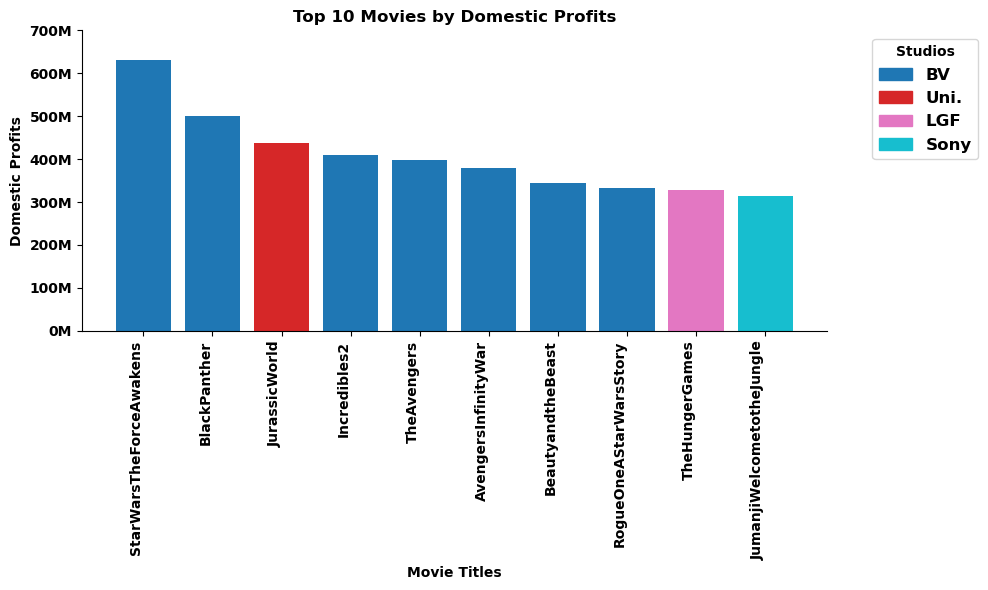

In [336]:
df_sorted = merged_df6_q1_df.sort_values(by='domestic_Profit', ascending=False)
df_sorted.loc[95 , 'studio'] = 'BV'


#Get a list of Top 10 movies by profit
top_10_movies = df_sorted.head(10)

#Get unique studios
unique_studios = top_10_movies['studio'].unique()

#Define colors for each unique studio
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_studios)))

#Create a dictionary to map studios to colors
color_dict = dict(zip(unique_studios, colors))

#Set font properties to be bolder
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 'large'

#Plotting
plt.figure(figsize=(10, 6))

#Iterate over each movie and plot its bar with corresponding color
for i, (movie, profit, studio) in enumerate(zip(top_10_movies['movie'], top_10_movies['domestic_Profit'], top_10_movies['studio'])):
    plt.bar(i, profit, color=color_dict.get(studio, 'gray'), label=studio)

#Create a custom legend with only the unique studios
handles = [plt.Rectangle((0,0),1,1, color=color_dict[studio]) for studio in unique_studios]
labels = unique_studios
plt.legend(handles, labels, title='Studios', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Movie Titles')
plt.ylabel('Domestic Profits')
plt.title('Top 10 Movies by Domestic Profits')
plt.xticks(np.arange(10), top_10_movies['movie'], rotation=45, ha='right')  # Set x-axis ticks and labels
y_ticks = np.arange(0, 800, 100) * 1e6
plt.yticks(y_ticks, ['{:.0f}M'.format(y_tick/1e6) for y_tick in y_ticks])
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Master dataframe

In [337]:
merged_df6_q1_df.to_csv('masterdf.csv', index=False)

In [338]:
merged_df6_q1_df.head()

,release_date,movie,production_budget,domestic_gross,genres,studio,foreign_gross,domestic_ROI_percent,domestic_Profit
0,2011-05-20,PiratesoftheCaribbeanOnStrangerTides,410600000,241063875,"Action,Adventure,Fantasy",BV,804600000,58.710150,-169536125
1,2015-05-01,AvengersAgeofUltron,330600000,459005868,"Action,Adventure,Sci-Fi",BV,946400000,138.840250,128405868
2,2017-12-15,StarWarsTheLastJedi,317000000,620181382,"Action,Adventure,Fantasy",BV,712400000,195.640815,303181382
3,2015-12-18,StarWarsTheForceAwakens,306000000,936662225,"Action,Adventure,Fantasy",BV,"1,131.6",306.098766,630662225
4,2018-04-27,AvengersInfinityWar,300000000,678815482,"Action,Adventure,Sci-Fi",BV,"1,369.5",226.271827,378815482


# Linear Regression 

In [339]:
#We create a new column 'year'
merged_df6_q1_df['year'] = merged_df6_q1_df['release_date'].dt.year


In [340]:
#We filtered the DataFrame for movies produced by studio BV
bv_movies = merged_df6_q1_df[merged_df6_q1_df['studio'] == 'BV']

#We group the filtered DataFrame by release year and calculate the mean profit for each year
mean_profit_per_year = bv_movies.groupby('year')['domestic_Profit'].mean()

#We convert the resulting series to DataFrame if needed
mean_profit_per_year_df = mean_profit_per_year.reset_index()

#We set the mean profit per year for studio BV as a new variable
mean_profit_bv = mean_profit_per_year_df
mean_profit_bv['domestic_Profit'] = mean_profit_bv['domestic_Profit'] / 10000000

print(mean_profit_bv)

   year  domestic_Profit
0  2010         1.904062
1  2011        -0.702236
2  2012         4.935176
3  2013         5.198529
4  2014         5.000415
5  2015        11.369368
6  2016         8.188550
7  2017         9.720646
8  2018        15.928362


In [341]:
#We reshaped X and Y to have compatible shapes
X = np.array(mean_profit_bv['year'])
Y = np.array(mean_profit_bv['domestic_Profit'])
X_plus_c = sm.add_constant(X)

model = sm.OLS(Y, X_plus_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     31.24
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           0.000825
Time:                        17:20:41   Log-Likelihood:                -19.177
No. Observations:                   9   AIC:                             42.35
Df Residuals:                       7   BIC:                             42.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3351.2865    600.789     -5.578      0.001   -4771.927   -1930.646
x1             1.6674      0.298      5.590      0.001       0.962       2.373
==============================================================================
Omnibus:                        4.343   Durbin-Watson:                   2.829
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                1.079
Skew:                           0.078   Prob(JB):                        0.583
Kurtosis:                       1.311   Cond. No.                     1.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

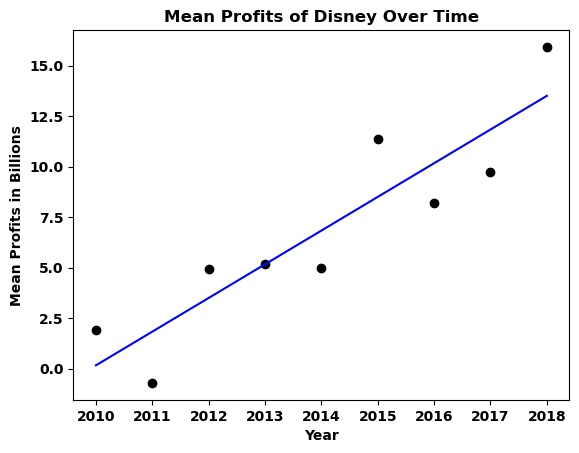

In [342]:
#use green as color for individual points 
plt.plot(X, Y, 'o', color='black') 
 
#obtain m (slope) and b(intercept) of linear regression line 
m, b = np.polyfit(X, Y, 1) 
 
#use red as color for regression line 
plt.plot(X, m*X+b, color='blue')

plt.xlabel('Year')
plt.ylabel('Mean Profits in Billions')
plt.title('Mean Profits of Disney Over Time');

In [343]:
def sse(m):
    # sum of squared errors
    line = m*X
    err = sum(X**2 for x in [line - model.predict(X_plus_c)])
    return sum(err)

sse(1.6674)

36505824

In [344]:
bv_movies['domestic_Profit'].mean()

64383793.975

When evaluating a model to assess Disney profit, our null hypothesis is that there is no change in mean profit over a period of eight years. The alternative hypothesis is that there is a significant change in mean profit over a period of 8 years. 

The p-value of our model is 0.001. With an alpha value of 0.05, this indicates that we can reject the null hypothesis, indicating that there Disney experienced a significant change in mean profit over a period of 8 years. 

Additionally, our R-squared value of 0.817 indicates that 81.7% of the model accounts for variation in profit, which we find significant.

# Conclusion 

Partnering with Disney can be a strategic move for movie producers. The studio's strong brand reputation and extensive market reach can significantly boost a film's profitability. Additionally, working with Disney can lead to increased profits regardless of the release window. While summertime traditionally provides an optimal window for movie releases due to higher audience attendance, collaborating with Disney can elevate profits at any time of the year.

Furthermore, analyzing genre trends reveals that adventure, comedy, and action genres tend to generate the highest profits. By aligning with these popular genres, filmmakers can capitalize on audience preferences and maximize their revenue potential.